In [192]:
import pandas as pd
import ast
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import OneHotEncoder

# Load the datasets (replace 'ratings.csv' and 'wine_characteristics.csv' with the actual CSV file paths)
ratings_data = pd.read_csv('Dataset/last/XWines_Slim_150K_ratings.csv')
wine_data = pd.read_csv('Dataset/last/XWines_Slim_1K_wines.csv')
group_data = pd.read_csv('Dataset/last/group_composition.csv')  # Add path to your group CSV

# Merge the two datasets on 'WineID'
merged_data = pd.merge(ratings_data, wine_data, on='WineID')

# 1. Function: Extract group members based on group_id
def extract_group_members(group_df, group_id):
    """
    Extracts the members of a group based on the group_id.
    """
    group_row = group_df[group_df['group_id'] == group_id]
    if group_row.empty:
        print(f"Group ID {group_id} not found.")
        return None

    group_members_str = group_row['group_members'].values[0]
    group_members = ast.literal_eval(group_members_str)  # Convert string to list
    return group_members


# 2. Function: Filter ratings for group members
def get_group_ratings(group_members, ratings_df):
    """
    Returns the ratings of the group members.
    """
    return ratings_df[ratings_df['UserID'].isin(group_members)]


# 3. Function: Calculate group preferences (top categories)
def calculate_group_preferences(group_ratings, merged_data):
    """
    Calculates the top categories based on the preferences of group members.
    """
    # Group ratings by WineID and calculate the average rating
    top_wines = group_ratings.groupby('WineID')['Rating'].mean().reset_index()
    
    # Merge with wine data to get wine characteristics
    wine_details = merged_data[merged_data['WineID'].isin(top_wines['WineID'])]

    # Calculate the frequency of 'Type' and 'Body' features in top-rated wines
    category_weights = {"Type": wine_details['Type'].value_counts().to_dict(),
                        "Body": wine_details['Body'].value_counts().to_dict()}
    
    return category_weights


# 4. Function: KNN modeling for similar wines
def find_knn_recommendations(group_ratings, merged_data, k=10):
    """
    Finds similar wines based on the characteristics of wines rated by the group.
    """
    features = ['Type', 'Body']
    wine_features = merged_data[features]

    # One-hot encoding for the features
    encoder = OneHotEncoder(sparse_output=False)
    encoded_wine_features = encoder.fit_transform(wine_features)

    # KNN model
    knn_model = NearestNeighbors(n_neighbors=k, metric='euclidean')
    knn_model.fit(encoded_wine_features)

    # Find similar wines for each top-rated wine
    group_top_wines = group_ratings['WineID'].unique()
    similar_wines = []
    for wine_id in group_top_wines:
        target_wine = merged_data[merged_data['WineID'] == wine_id][features]
        if target_wine.empty:
            continue

        encoded_target_wine = encoder.transform(target_wine)
        distances, indices = knn_model.kneighbors(encoded_target_wine)

        # Store similar wines for this wine
        similar_wines.append(merged_data.iloc[indices[0]][['WineID', 'Type', 'Body']])

    # Combine all similar wines
    similar_wines_df = pd.concat(similar_wines)
    return similar_wines_df.drop_duplicates()


# 5. Function: Select the best wine based on preferences
def get_best_wine_based_on_preferences(category_weights, merged_data, n):
    """
    Selects the best wine based on top categories.
    """
    # Sort by top categories
    sorted_type = sorted(category_weights['Type'].items(), key=lambda x: x[1], reverse=True)[0][0]
    sorted_body = sorted(category_weights['Body'].items(), key=lambda x: x[1], reverse=True)[0][0]

    # Find a wine with these characteristics
    best_wine = merged_data[(merged_data['Type'] == sorted_type) & (merged_data['Body'] == sorted_body)]
    
    if not best_wine.empty:
        return best_wine.sort_values(by='AvgRating', ascending=False).head(n)
    else:
        return None


C:\Users\antoi\AppData\Local\Temp\ipykernel_24524\1725064027.py:7: DtypeWarning:

Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.



In [193]:
# Load the ratings dataset (replace 'ratings.csv' with your actual file path)
ratings_data = pd.read_csv('Dataset/last/XWines_Slim_150K_ratings.csv')

# Group by 'user_id' and find the maximum rating for each user
user_max_ratings = ratings_data.groupby('UserID')['Rating'].max()

# Filter to get only users whose max rating was 3
users_with_max_rating_3 = user_max_ratings[user_max_ratings == 3].index

# Print the list of users whose maximum rating was 3
print("Users whose maximum rating was 3:")
print(users_with_max_rating_3)


Users whose maximum rating was 3:
Index([1006724, 1056257, 1145862, 1196247, 1197650, 1220278, 1245717, 1279250,
       1290651, 1316369, 1334222, 1380716, 1391592, 1393496, 1397551, 1400386,
       1406797, 1420747, 1558571, 1563515, 1664756, 1719976, 1760544, 1762859,
       1781649, 1816088, 1843929, 1936578, 1944444, 1977712, 1997980, 2061195],
      dtype='int64', name='UserID')


C:\Users\antoi\AppData\Local\Temp\ipykernel_24524\1722683622.py:2: DtypeWarning:

Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.



In [194]:
# create average rating for each wine

ratings = {}
for index, row in ratings_data.iterrows():
    if row['WineID'] not in ratings:
        ratings[row['WineID']] = {"total": row['Rating'], "count": 1}
    else:
        ratings[row['WineID']]["total"] += row['Rating']
        ratings[row['WineID']]["count"] += 1

# add the averages to the df

wine_data["AvgRating"] = 0.0

for index, row in wine_data.iterrows():
    wine_data.loc[index, "AvgRating"] = ratings[row["WineID"]]["total"]/ratings[row["WineID"]]["count"]

In [195]:
def recommend_for_group(group_id, group_data, ratings_data, merged_data, k=10, wine_id_only=False, n=5):
    # Step 1: Extract group members based on group_id
    group_members = extract_group_members(group_data, group_id)
    if not group_members:
        return "Group not found!"

    # Step 2: Filter ratings for group members
    group_ratings = get_group_ratings(group_members, ratings_data)

    # Step 3: Calculate group preferences
    category_weights = calculate_group_preferences(group_ratings, merged_data)

    # Step 4: Find similar wines using KNN
    knn_recommendations = find_knn_recommendations(group_ratings, merged_data, k)

    # Step 5: Select the best wine based on preferences
    best_wine = get_best_wine_based_on_preferences(category_weights, merged_data, n)

    return best_wine["WineID"]


In [196]:
import pandas as pd
import ast  # Import to safely parse string representation of lists

def get_wines_rated_by_group(group_df, group_id, ratings_df, wine_id=None):

    # Step 1: Extract the group_members string using the group_id
    group_row = group_df[group_df['group_id'] == group_id]

    # Step 2: Check if group_members list is found
    if group_row.empty:
        print(f"Group ID {group_id} not found.")
        return pd.DataFrame(columns=['UserID', 'WineID', 'Rating'])
    
    # Step 3: Convert the group_members string into an actual list
    group_members_str = group_row['group_members'].values[0]
    group_members = ast.literal_eval(group_members_str)  # Safely convert string to list
    
    # Step 4: Filter ratings_data for rows where UserID is in the group_members list
    filtered_ratings = ratings_df[ratings_df['UserID'].isin(group_members)]
    
    # Step 5: If wine_id is provided, filter further for that specific WineID
    if wine_id is not None:
        filtered_ratings = filtered_ratings[filtered_ratings['WineID'] == wine_id]

    # Step 6: Return the filtered DataFrame
    return filtered_ratings[['UserID', 'WineID', 'Rating']]

In [197]:
def get_wines_rated_by_group(group_df, group_id, ratings_df, wine_id=None):
    # Step 1: Extract group members based on `group_id`
    group_row = group_df[group_df['group_id'] == group_id]

    # Step 2: Check if the group ID exists
    if group_row.empty:
        print(f"Group with ID {group_id} not found.")
        return pd.DataFrame(columns=['UserID', 'WineID', 'Rating'])

    # Step 3: Convert the `group_members` string to a list
    group_members_str = group_row['group_members'].values[0]
    group_members = ast.literal_eval(group_members_str)  # Safely convert string to list

    # Step 4: Filter `ratings_df` for UserIDs in the `group_members` list
    filtered_ratings = ratings_df[ratings_df['UserID'].isin(group_members)]

    # Step 5: If `wine_id` is provided, filter further
    if wine_id is not None:
        # Use `isin` if `wine_id` is a list
        if isinstance(wine_id, list):
            filtered_ratings = filtered_ratings[filtered_ratings['WineID'].isin(wine_id)]
        else:
            # Otherwise, filter for a single WineID
            filtered_ratings = filtered_ratings[filtered_ratings['WineID'] == wine_id]

    # Step 6: Return the filtered DataFrame
    return filtered_ratings[['UserID', 'WineID', 'Rating']]


In [198]:
import pandas as pd

# Assuming `group_data`, `ratings_data`, and `wine_data` are already defined DataFrames.

# Step 1: Create an empty list to store average ratings for each group
group_avg_ratings = []

# Step 2: Iterate over all group IDs (0 to 239)
for group_id in range(240):
    # Get the top 5 wine recommendations for the current group
    recommended_wines = recommend_for_group(
        group_id=group_id,
        group_data=group_data,
        ratings_data=ratings_data,
        merged_data=wine_data,
        wine_id_only=True,
        n=5
    )
    
    # Convert the WineIDs to a list, if necessary
    wine_id_list = recommended_wines if isinstance(recommended_wines, list) else recommended_wines.values.tolist()

    # Step 3: Get the ratings of group members for the recommended wines
    group_ratings_df = get_wines_rated_by_group(
        group_df=group_data,
        group_id=group_id,
        ratings_df=ratings_data,
        wine_id=wine_id_list
    )
    
    # Step 4: Calculate the average rating for the returned wines
    if not group_ratings_df.empty:
        avg_rating = group_ratings_df['Rating'].mean()
    else:
        avg_rating = None  # No ratings found

    # Step 5: Store the result as a tuple (GroupID, AverageRating)
    group_avg_ratings.append((group_id, avg_rating))

# Step 6: Output the average ratings for each group
group_avg_ratings_df = pd.DataFrame(group_avg_ratings, columns=["GroupID", "AverageRating"])


In [199]:
import plotly.express as px

# Create an interactive bar chart
fig = px.bar(group_avg_ratings_df, x='GroupID', y='AverageRating',
             labels={'GroupID': 'Group ID', 'AverageRating': 'Average Rating'},
             title='Average Wine Rating per Group')

# Show the interactive chart
fig.show()


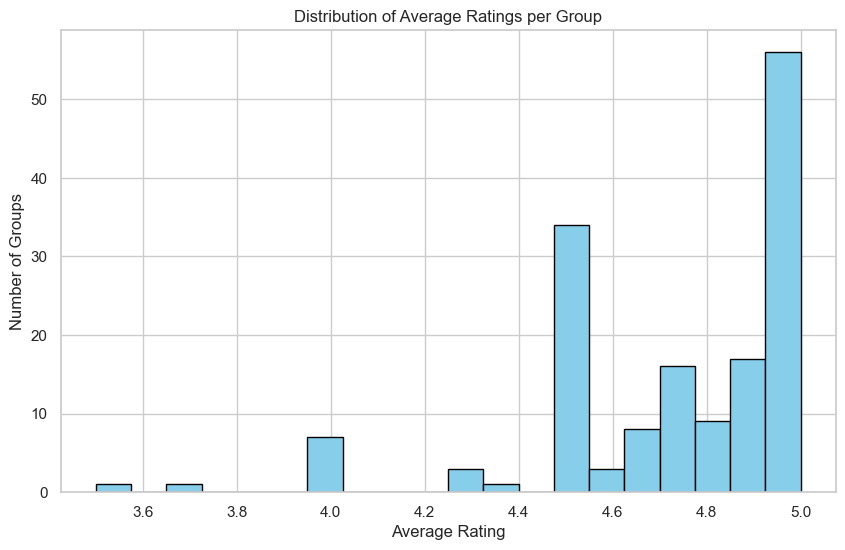

In [200]:
import matplotlib.pyplot as plt

# Create a histogram of average ratings per group
plt.figure(figsize=(10, 6))
plt.hist(group_avg_ratings_df['AverageRating'].dropna(), bins=20, color='skyblue', edgecolor='black')

# Add labels and title in English
plt.xlabel('Average Rating')
plt.ylabel('Number of Groups')
plt.title('Distribution of Average Ratings per Group')

# Show the histogram
plt.show()


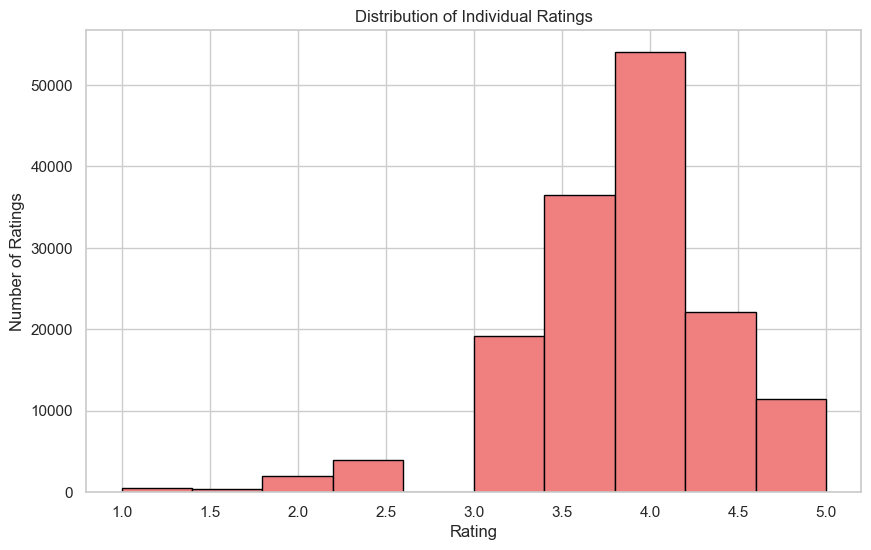

In [201]:
plt.figure(figsize=(10, 6))
plt.hist(ratings_data['Rating'], bins=10, color='lightcoral', edgecolor='black')

# Add labels and title in English
plt.xlabel('Rating')
plt.ylabel('Number of Ratings')
plt.title('Distribution of Individual Ratings')

# Show the histogram
plt.show()


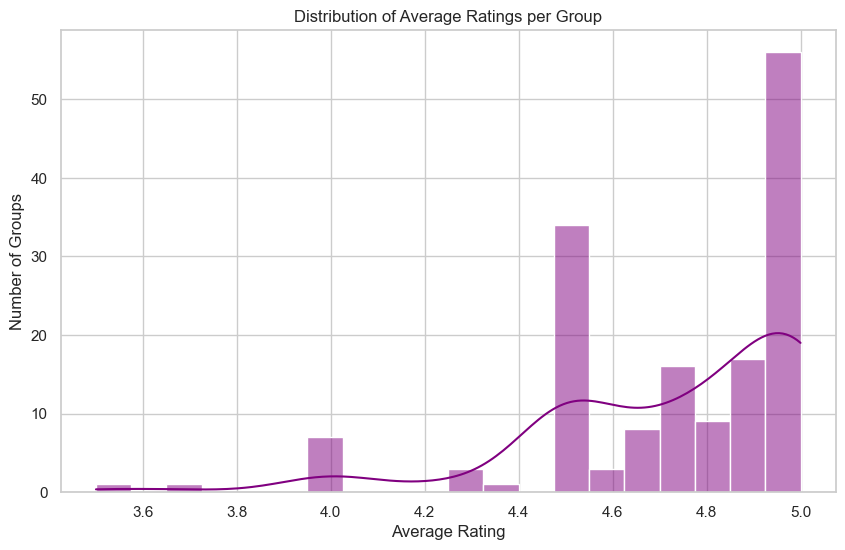

In [202]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style for the histogram
sns.set(style="whitegrid")

# Create the histogram
plt.figure(figsize=(10, 6))
sns.histplot(group_avg_ratings_df['AverageRating'].dropna(), bins=20, kde=True, color='purple')

# Add labels and title in English
plt.xlabel('Average Rating')
plt.ylabel('Number of Groups')
plt.title('Distribution of Average Ratings per Group')

# Show the histogram
plt.show()


In [215]:
def calculate_least_misery(group_id, group_data, ratings_data, wine_data, n=5):
    # Step 1: Get the top n recommended wines for the group
    recommended_wine_ids = recommend_for_group(group_id, group_data, ratings_data, wine_data, wine_id_only=True, n=n)

    # Convert recommended_wine_ids to a list (if it's a Series or another object)
    if not isinstance(recommended_wine_ids, list):
        recommended_wine_ids = recommended_wine_ids.tolist()

    # Step 2: Get ratings of the group members for these recommended wines
    group_ratings_df = get_wines_rated_by_group(group_data, group_id, ratings_data, wine_id=recommended_wine_ids)

    # Step 3: Check if group_ratings_df is empty, which means no ratings for these wines by group members
    if group_ratings_df.empty:
        return pd.DataFrame(columns=['WineID', 'LeastMiseryScore'])

    # Step 4: Calculate Least Misery: the minimum rating for each recommended WineID within the group
    least_misery_df = group_ratings_df[group_ratings_df['WineID'].isin(recommended_wine_ids)].groupby('WineID')['Rating'].min().reset_index()
    least_misery_df.columns = ['WineID', 'LeastMiseryScore']

    return least_misery_df


In [216]:
# Iterate over all group IDs and calculate the Least Misery score for each group
all_group_least_misery = []  # Initialize an empty list to store results

for group_id in range(240):  # Assuming there are 240 groups (IDs 0 to 239)
    try:
        # Calculate least misery for the current group
        least_misery_df = calculate_least_misery(group_id, group_data, ratings_data, wine_data, n=5)
        
        # Check if the DataFrame is not empty before appending
        if not least_misery_df.empty:
            # Append group ID to the result for better tracking
            least_misery_df['GroupID'] = group_id
            all_group_least_misery.append(least_misery_df)
    except Exception as e:
        print(f"Error processing Group ID {group_id}: {e}")

# Ensure that there are DataFrames to concatenate
if all_group_least_misery:
    # Concatenate the results for all groups into a single DataFrame
    least_misery_results_df = pd.concat(all_group_least_misery, ignore_index=True)


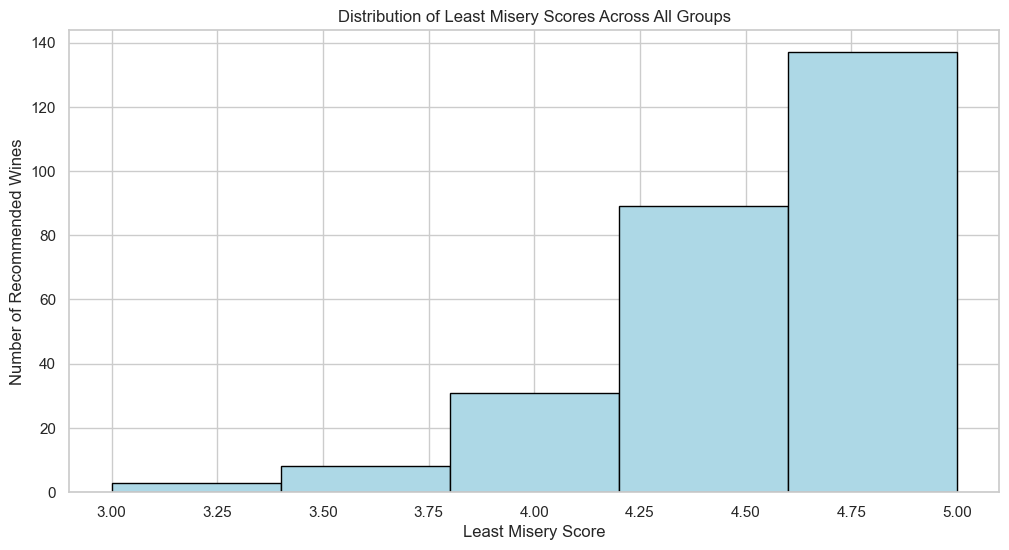

In [205]:
import matplotlib.pyplot as plt

# Create a histogram of Least Misery Scores
plt.figure(figsize=(12, 6))
plt.hist(least_misery_results_df['LeastMiseryScore'], bins=5, color='lightblue', edgecolor='black')
plt.xlabel('Least Misery Score')
plt.ylabel('Number of Recommended Wines')
plt.title('Distribution of Least Misery Scores Across All Groups')
plt.show()


In [206]:
import pandas as pd
import numpy as np

def calculate_fairness(group_ratings_df):
    # Calculate standard deviation of ratings within the group for the recommended wines
    if group_ratings_df.empty or len(group_ratings_df['Rating'].unique()) == 1:
        # If there is only one unique rating or no ratings, fairness is 1 (perfect fairness)
        return 1.0

    std_dev = group_ratings_df['Rating'].std()  # Standard deviation of ratings

    # Calculate Fairness: 1 - (std deviation) / (max rating - min rating)
    fairness = 1 - (std_dev / (5 - 1))  # Using 5 as max and 1 as min rating

    return round(fairness, 2)  # Return the Fairness score rounded to 2 decimal places

# Beispiel: Berechnung der Fairness für alle Gruppen
group_fairness_scores = []  # Store the fairness scores for each group

for group_id in range(240):  # Assuming there are 240 groups
    try:
        # Get ratings for the group and recommended wines
        group_ratings_df = get_wines_rated_by_group(group_data, group_id, ratings_data, wine_id=None)  # Get all ratings for the group

        # Calculate fairness for the current group
        fairness_score = calculate_fairness(group_ratings_df)
        
        # Store group ID and fairness score
        group_fairness_scores.append({'GroupID': group_id, 'FairnessScore': fairness_score})
    
    except Exception as e:
        print(f"Error processing Group ID {group_id}: {e}")

# Convert to DataFrame for better visualization
fairness_df = pd.DataFrame(group_fairness_scores)



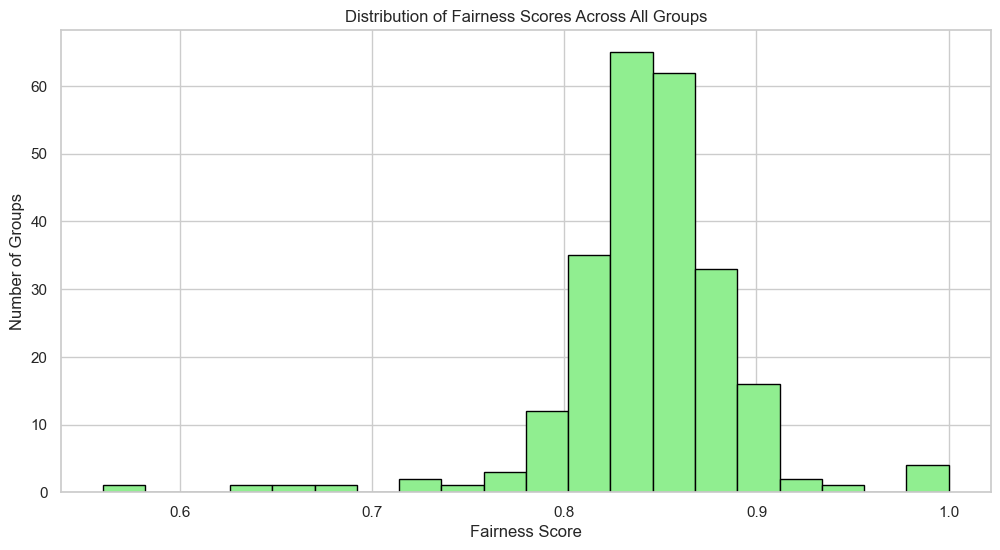

In [207]:
import matplotlib.pyplot as plt

# Create a histogram of fairness scores
plt.figure(figsize=(12, 6))
plt.hist(fairness_df['FairnessScore'], bins=20, color='lightgreen', edgecolor='black')
plt.xlabel('Fairness Score')
plt.ylabel('Number of Groups')
plt.title('Distribution of Fairness Scores Across All Groups')
plt.show()


C:\Users\antoi\AppData\Local\Temp\ipykernel_24524\2448386283.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




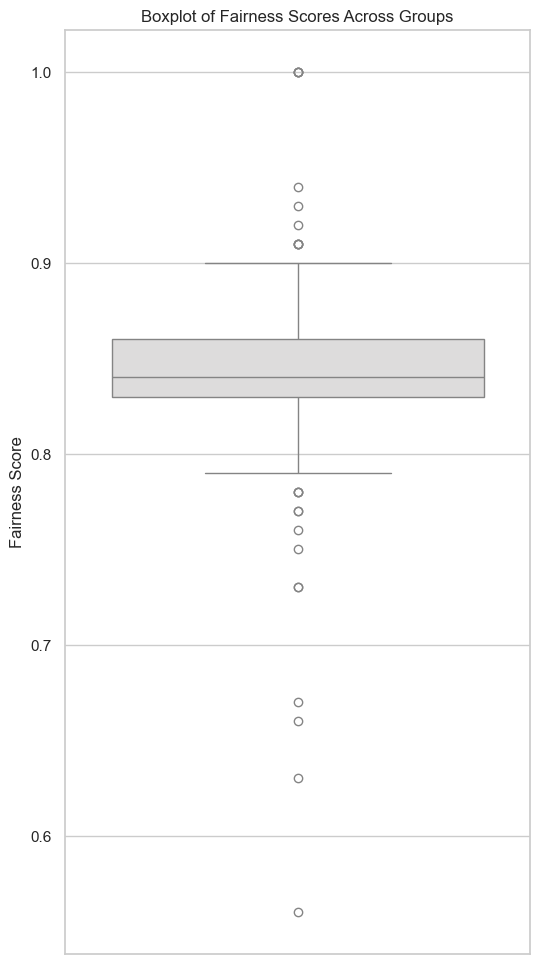

In [208]:
import seaborn as sns

# Create a boxplot to visualize the fairness scores across groups
plt.figure(figsize=(6, 12))
sns.boxplot(y='FairnessScore', data=fairness_df, palette='coolwarm')
plt.ylabel('Fairness Score')
plt.title('Boxplot of Fairness Scores Across Groups')
plt.show()


In [209]:
import pandas as pd

def calculate_satisfaction_rate(group_ratings_df, threshold=4):

    # Step 1: Check if the DataFrame is empty
    if group_ratings_df.empty:
        return 0.0

    # Step 2: Calculate satisfaction for each wine
    # Group by WineID and calculate the percentage of group members rating >= threshold
    satisfaction_df = group_ratings_df.groupby('WineID').apply(
        lambda x: (x['Rating'] >= threshold).mean()
    ).reset_index()
    
    # Step 3: Calculate Satisfaction Rate: Proportion of wines with a satisfaction rate >= 0.5
    satisfaction_df.columns = ['WineID', 'SatisfactionPercentage']
    satisfaction_rate = (satisfaction_df['SatisfactionPercentage'] >= 0.5).mean()

    return round(satisfaction_rate, 2)  # Return the satisfaction rate rounded to 2 decimal places

# Beispiel: Berechnung der Satisfaction Rate für alle Gruppen
group_satisfaction_scores = []  # Store the satisfaction rate for each group

for group_id in range(240):  # Assuming there are 240 groups
    try:
        # Get ratings for the group and recommended wines
        group_ratings_df = get_wines_rated_by_group(group_data, group_id, ratings_data, wine_id=None)  # Get all ratings for the group

        # Calculate satisfaction rate for the current group
        satisfaction_rate = calculate_satisfaction_rate(group_ratings_df)
        
        # Store group ID and satisfaction rate
        group_satisfaction_scores.append({'GroupID': group_id, 'SatisfactionRate': satisfaction_rate})
    
    except Exception as e:
        print(f"Error processing Group ID {group_id}: {e}")

# Convert to DataFrame for better visualization
satisfaction_df = pd.DataFrame(group_satisfaction_scores)


C:\Users\antoi\AppData\Local\Temp\ipykernel_24524\810600251.py:20: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

C:\Users\antoi\AppData\Local\Temp\ipykernel_24524\810600251.py:20: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

C:\Users\antoi\AppData\Local\Temp\ipykernel_24524\810600251.py:20: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a f

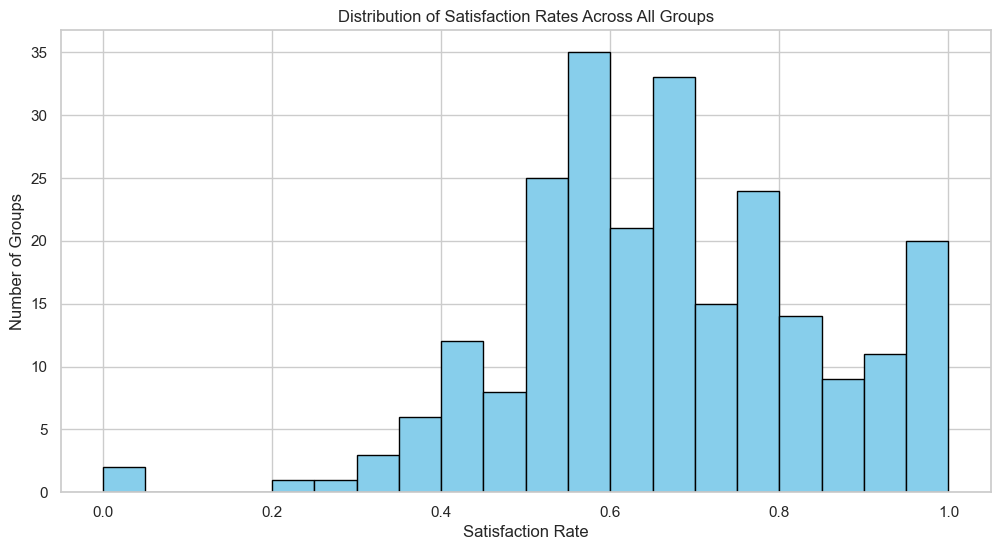

In [210]:
import matplotlib.pyplot as plt

# Create a histogram of satisfaction rates
plt.figure(figsize=(12, 6))
plt.hist(satisfaction_df['SatisfactionRate'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Satisfaction Rate')
plt.ylabel('Number of Groups')
plt.title('Distribution of Satisfaction Rates Across All Groups')
plt.show()


C:\Users\antoi\AppData\Local\Temp\ipykernel_24524\3479752945.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




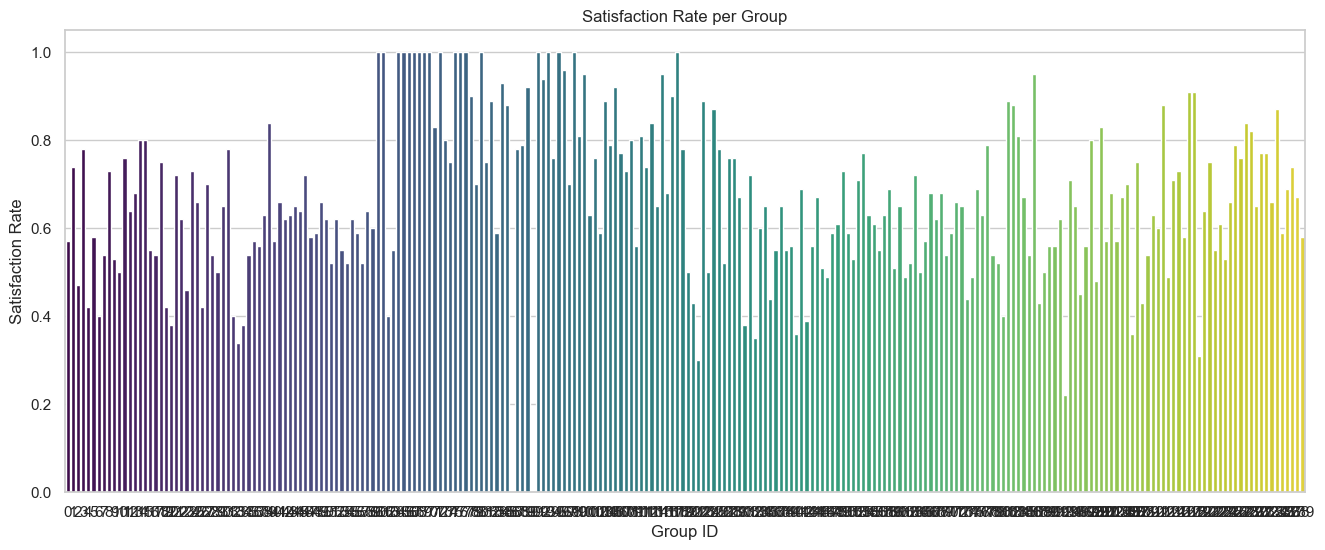

In [211]:
import seaborn as sns

# Create a bar plot to visualize the satisfaction rates per group
plt.figure(figsize=(16, 6))
sns.barplot(x='GroupID', y='SatisfactionRate', data=satisfaction_df, palette='viridis')
plt.xlabel('Group ID')
plt.ylabel('Satisfaction Rate')
plt.title('Satisfaction Rate per Group')
plt.show()
